# Quadtree decomposition with <i>kite</i>

The <i><a href="https://pyocko.org">pyrocko</a></i> suite of tools comprise a series of open source applications designed to simplify the modeling of earthquakes, using both seismic and InSAR data. Here we will use one of those applications, <i>kite</i>, to read in and downsample an ISCE interferogram using quadtree decomposition.

## Setup

First, we load in a load of modules:

In [1]:
import numpy as np
from kite import Scene
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import math
from osgeo import gdal

Next, we specify a path and some filenames:

In [2]:
ifgpath="/home/gareth/stuffs/work/quakes/elazig/merged/" # directory with your interferogram
ifgname="filt_topophase.unw.geo"                                      # interferogram file
corname="topophase.cor.geo"                                           # correlation file
mskname="water.msk"                                                   # water mask file

Here are a couple of important parameters. <i>kite</i> currently cannot read in the radar wavelength from the interferogram metadata, as it is not included in the xml file(!) and so we specify it here. We also supply a correlation threshold for masking out low correlation data points.

In [3]:
wavel = 0.0555     # radar wavelength in m
cor_thresh = 0.2  # correlation threshold between 0 (bad) and 1 (perfect)

## Load in the interferogram

It is  a single command to read in an interferogram with <i>kite:</i>

In [4]:
sc = Scene.import_data(ifgpath+ifgname)

We can look and see what we imported using a few matplotlib commands

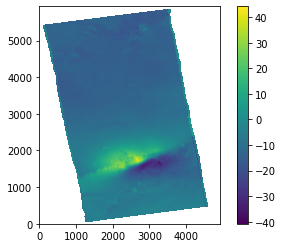

In [5]:
#matplotlib inline
fig, ax1 = plt.subplots()                       # new figure called "ax1"
im = ax1.imshow(sc.displacement,origin='lower') # plot displacements with origin at lower left (kite default)
fig.colorbar(im)                                # plot a color bar!
plt.show();

## Masking and unit conversion

A freshly unwrapped and loaded interferogram will not have been masked for 'bad' (low correlation) data points, or for water. If we include these in our downsampled data, we will be corrupting our data with errors. We can use a combination of gdal and numpy to load in the correlation and water mask files, and replace them with NaNs (which is how <i>kite</i> treats null data). First, load them in:

In [6]:
# correlation file
corfile=gdal.Open(ifgpath+corname,gdal.GA_ReadOnly)   # open with gdal
rb = corfile.GetRasterBand(2)                         # correlation info is in band 2
cor = rb.ReadAsArray()                                # read it in as a number array
cor=np.flip(cor,0)                                    # flip image to account for origin position
                                                      # (kite prefers lower left; ISCE, top left)

# water mask file
mskfile=gdal.Open(ifgpath+mskname,gdal.GA_ReadOnly)  
rb = mskfile.GetRasterBand(1)                         # only one band here
msk = rb.ReadAsArray()
msk=np.flip(msk,0)

We can convert the interferogram from radians to meters (ISCE does not include wavelength information in the interferogram metadata files, so it is not applied automatically by <i>kite</i>):

In [7]:
sc.displacement*=wavel/4/math.pi   # change values of sc.displacement in place

Next, replace the zeros in the water mask, and values with low correlation, by NaNs:

In [8]:
sc.displacement[msk<1]=np.nan
sc.displacement[cor<cor_thresh]=np.nan

And plot to see if it worked!

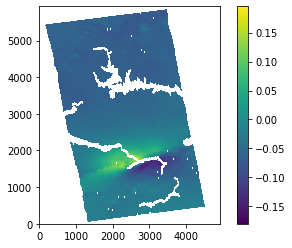

In [9]:
#matplotlib inline
fig, ax2 = plt.subplots()
im = ax2.imshow(sc.displacement,origin='lower')
cb=fig.colorbar(im)

## Quadtree decomposition

We can initialize the quadtree decomposition in <i>kite</i> by defining an abbreviation:

In [10]:
qt = sc.quadtree

And we can specify some parameters that control the quadtree process:

In [11]:
qt.epsilon = 0.02         # Variance threshold
qt.nan_allowed = 0.5      # Percentage of NaN values allowed per tile/leaf
qt.tile_size_max = 0.2    # Maximum leaf size in degrees
qt.tile_size_min = 0.01  # Minimum leaf size in degrees

Let's look at the distribution of leaves/tiles. Typically we are looking for a few hundred... If you don't like what you have, try editing the values above and re-running. If you would like more leaves, lower the epsilon value and/or make the tile sizes smaller. If you want fewer, do the opposite!

In [12]:
print("There are",qt.nleaves,"leaves")

There are 181 leaves


And if you want to see the quadtree results, you can. This example prints out the leaf number, the lower left ('ll') east and north coordinates of the leaf (with respect to the lower left of the whole image), and the mean displacement of the pixels in that leaf:

In [131]:
j=0
for k in qt.leaves:
    print("leaf",j,"llE:",qt.leaves[j].llE,"llN:",qt.leaves[j].llN,"mean:",qt.leaves[j].mean) 
    j=j+1

leaf 0 llE: 0.35555555555555557 llN: 0.0 mean: -0.019630571827292442
leaf 1 llE: 0.35555555555555557 llN: 0.07111111111111111 mean: -0.018841003999114037
leaf 2 llE: 0.42666666666666664 llN: 0.0 mean: -0.018467135727405548
leaf 3 llE: 0.49777777777777776 llN: 0.0 mean: -0.02403281442821026
leaf 4 llE: 0.42666666666666664 llN: 0.07111111111111111 mean: -0.020989419892430305
leaf 5 llE: 0.49777777777777776 llN: 0.07111111111111111 mean: -0.030090466141700745
leaf 6 llE: 0.35555555555555557 llN: 0.14222222222222222 mean: -0.019581995904445648
leaf 7 llE: 0.35555555555555557 llN: 0.21333333333333332 mean: -0.012556333094835281
leaf 8 llE: 0.42666666666666664 llN: 0.14222222222222222 mean: -0.023169120773673058
leaf 9 llE: 0.49777777777777776 llN: 0.14222222222222222 mean: -0.021668851375579834
leaf 10 llE: 0.42666666666666664 llN: 0.21333333333333332 mean: -0.017656568437814713
leaf 11 llE: 0.49777777777777776 llN: 0.21333333333333332 mean: -0.02317832037806511
leaf 12 llE: 0.2844444444444

leaf 261 llE: 0.28444444444444444 llN: 1.3511111111111112 mean: -0.060769155621528625
leaf 262 llE: 0.35555555555555557 llN: 1.3511111111111112 mean: -0.06502772122621536
leaf 263 llE: 0.42666666666666664 llN: 1.28 mean: -0.06426467001438141
leaf 264 llE: 0.49777777777777776 llN: 1.28 mean: -0.06621898710727692
leaf 265 llE: 0.42666666666666664 llN: 1.3511111111111112 mean: -0.0659228190779686
leaf 266 llE: 0.49777777777777776 llN: 1.3511111111111112 mean: -0.06838865578174591
leaf 267 llE: 0.07111111111111111 llN: 1.4222222222222223 mean: -0.058362655341625214
leaf 268 llE: 0.14222222222222222 llN: 1.4222222222222223 mean: -0.05809347331523895
leaf 269 llE: 0.21333333333333332 llN: 1.4222222222222223 mean: -0.05745531991124153
leaf 270 llE: 0.14222222222222222 llN: 1.4933333333333334 mean: -0.05783553048968315
leaf 271 llE: 0.21333333333333332 llN: 1.4933333333333334 mean: -0.05990314856171608
leaf 272 llE: 0.28444444444444444 llN: 1.4222222222222223 mean: -0.061443910002708435
leaf 2

And you can plot them too!

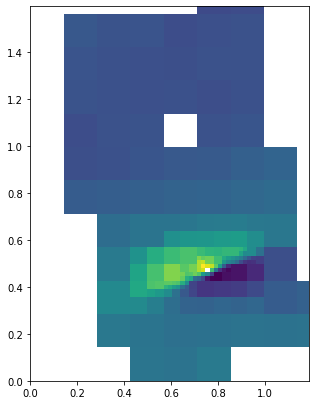

In [13]:
#matplotlib inline
fig, ax3 = plt.subplots(figsize=[5,7.5])

ulimit = qt.leaf_medians.max()
llimit = qt.leaf_medians.min()

color_map = cm.ScalarMappable(
    norm=colors.Normalize(vmin=llimit, vmax=ulimit))

for rect, leaf in zip(qt.getMPLRectangles(), qt.leaves):
    color = color_map.to_rgba(leaf.median)
    rect.set_facecolor(color)
    ax3.add_artist(rect)


ax3.set_xlim(0, qt.leaf_eastings.max())
ax3.set_ylim(0, qt.leaf_northings.max())
ax3.set_aspect('equal')


plt.show();

## Saving the output

This last section saves your files, both in <i>kite</i>'s internal format, and in a comma-separated variable file:

In [14]:
sc.save('elazig_asc_kite_scene')
#qt.export('elazig_asc_quadtree.csv')